In [1]:
# Packages for analysis
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from netCDF4 import Dataset,date2num,num2date
import pickle
# Packages for visuals
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.2)

# Allows charts to appear in the notebook
%matplotlib inline

import pyart
import numpy.ma as ma
import matplotlib.ticker as mticker
from matplotlib import colors as c
from matplotlib.colors import ListedColormap,BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.geodesic as cargeo
from shapely.geometry import Polygon
import os
import warnings
warnings.filterwarnings('ignore');


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\Admin\anaconda3\envs\pyart_env\lib\site-packages\wradlib\io\radolan.py:939: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "add_offset": np.float(0),
C:\Users\Admin\anaconda3\envs\pyart_env\lib\site-packages\wradlib\io\radolan.py:948: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "add_offset": np.float(0),
C:\Users\Admin\anaconda3

# Loading SVM model

In [3]:
model = pickle.load(open("A3/SVM_model_file_b4.pkl", "rb"))

In [17]:
#DEF
class UF:
    def __init__(self,radar,shape_grid,lat_0, lon_0):
        self.radar = radar
        self.shape_grid = shape_grid
        self.lat_0 = lat_0
        self.lon_0 = lon_0
    def remove_noises(self): #Step 3-A
        mask_noises_CC=ma.masked_less(self.radar.fields['cross_correlation_ratio']['data'],0.85)
        mask_noises_Z=ma.masked_less(self.radar.fields['reflectivity']['data'],0)
        rm_noises_Z_=np.ma.masked_array(self.radar.fields['reflectivity']['data'],mask_noises_CC.mask)
        rm_noises_Z=np.ma.masked_array(rm_noises_Z_,mask_noises_Z.mask)
        rm_noises_ZDR_=np.ma.masked_array(self.radar.fields['differential_reflectivity']['data'],mask_noises_CC.mask)
        rm_noises_ZDR=ma.masked_array(rm_noises_ZDR_,mask_noises_Z.mask)
        self.radar.add_field_like('reflectivity','Z_removed_noises',rm_noises_Z,replace_existing=True)
        self.radar.add_field_like('differential_reflectivity','ZDR_removed_noises', rm_noises_ZDR,replace_existing=True)
    def convert_grid(self):
        grid = pyart.map.grid_from_radars(
            self.radar,
            grid_shape=self.shape_grid, #Number of points in the grid (z, y, x)
            grid_limits=((0, 9000), (-200000, 200000), (-200000, 200000)), # min-max tuong duong z,y,x
            grid_origin = (self.lat_0, self.lon_0),
            fields=['Z_removed_noises',
                    'ZDR_removed_noises',
                    ],
            roi_func='dist_beam',
            weighting_function='cressman')
        return grid
    def convert_lat_lon(self, grid):
        #conver distance to lat/lon
        for i in range(self.shape_grid[1]):
            geog = pyart.core.cartesian_to_geographic_aeqd(grid.x["data"][i],grid.y["data"][i],self.lon_0, self.lat_0, R=6370997.0)
            grid.x["data"][i] = geog[0]
            grid.y["data"][i] = geog[1]
        return grid
    def SHY95_algorithm(self,Zh):
        Zh.mask=0
        SHY95=np.zeros((self.shape_grid[1],self.shape_grid[2]))
        #Step 1: Intensity
        mask_st1=(Zh>=40)
        SHY95[mask_st1]=1
        #Step 2: Peakeness
        def MBG(xo,yo,n,r,Zh): #Mean Background Reflectivity
            y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
            mask = x*x + y*y <= r*r
            Zh_none_O=Zh[xo,yo]
            Zbg_ = np.ma.masked_array(Zh[mask], Zh[mask] ==Zh_none_O) # remove value cycle centers
            Zbg = np.ma.masked_array(Zbg_, Zbg_ == 0) # remove 0 values
            return Zbg
        for xo in range (0,self.shape_grid[1],1):
            for yo in range (0,self.shape_grid[2],1):
                if SHY95[xo,yo]==0:
                    Zbg=MBG(xo,yo,self.shape_grid[1],5.5,Zh).mean()
                    deltaZh=Zh[xo,yo]-Zbg
                    if (Zbg < 42.43) and (deltaZh >= (10-Zbg**2/180)):
                        SHY95[xo,yo]=1
                    elif Zbg>=42.43 and deltaZh>=0:
                        SHY95[xo,yo]=1
        #Step3: Surrounding area
        def MBG_mask_r(xo,yo,n,r,): # mask array with r change
            y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
            mask = x*x + y*y <= r*r
            return mask
        medium=[25,30,35,40]
        for xo in range (0,self.shape_grid[1],1):
            for yo in range (0,self.shape_grid[2],1):
                if SHY95[xo,yo]==1:
                    Zbg=MBG(xo,yo,self.shape_grid[1],5.5,Zh).mean()
                    if Zbg < medium[0]:
                        r=0.5 #1km
                    elif Zbg>=medium[0] and Zbg <medium[1]:
                        r=1   #2km
                    elif Zbg>=medium[1] and Zbg <medium[2]: 
                        r=1.5 #3km
                    elif Zbg>=medium[2] and Zbg <medium[3]:
                        r=2   #4km
                    elif Zbg>=medium[3]:
                        r=2.5 #5km
                    mask_st2=MBG_mask_r(xo,yo,self.shape_grid[1],r=r)
                    SHY95[mask_st2]=2
        #Step4: remaining ares as stratiform
        for q in range (0,self.shape_grid[1],1):
            for l in range (0,self.shape_grid[2],1):
                if Zh[q,l] > 0 and SHY95[q,l] !=2:
                    SHY95[q,l]=1
        SHY95=ma.masked_equal(SHY95,0)
        return SHY95
    def SVM_algorithm(self,Zh_SVM,ZDR_SVM,model):
        SVM=np.zeros((shape_grid[1],shape_grid[2]))
        for xo in range (0,shape_grid[1],1):
            for yo in range (0,shape_grid[2],1):
                if Zh_SVM[xo,yo]!='masked' and ZDR_SVM[xo,yo]!='masked':
                    resuls=model.predict([[Zh_SVM[xo,yo], ZDR_SVM[xo,yo]]])
                    if resuls==2.0:
                        SVM[xo,yo]=2
                    elif resuls==1.0:
                        SVM[xo,yo]=1
        SVM=ma.masked_equal(SVM,0)
        return SVM
#Tạo giới hạn bán kính 200km    
y,x = np.ogrid[-100:201-100, -100:201-100]
mask = x*x + y*y > 100*100

In [18]:
#S_11,C_22,p_12,p_21,C_SVM,C_SHY95,S_SVM,S_SHY95=0,0,0,0,0,0,0,0

In [19]:
Case='General.xlsx'
Case_dic={Case:[*range(1,28,1)]}
POD_S=[]
POD_C=[]
FAR_S=[]
FAR_C=[]
CSI_S=[]
CSI_C=[]
ERR_S=[]
ERR_C=[]
BIAS_S=[]
BIAS_C=[]
for r in Case_dic[Case]:
    linkNC='D:/data/SVM_netCDF/'+Case[:-5]+'/'+str(r)+'/'
    print(linkNC)
    C_11,C_22,p_12,p_21,C_SVM,C_SHY95,S_SVM,S_SHY95=0,0,0,0,0,0,0,0
    for file_name in os.listdir(linkNC):
        data=Dataset(linkNC+file_name,'r') # at 1 time
        SVM=data.variables['CS_SVM'][0,:,:]
        SHY95=data.variables['CS_SHY95'][0,:,:]
        S_11=S_11+np.sum((SVM==1) & (SHY95==1)) # number of points SVM = SHY95 = Stratiform
        C_22=C_22+np.sum((SVM==2) & (SHY95==2)) # number of points SVM = SHY95 = Convection
        p_21=p_21+np.sum((SVM==2) & (SHY95==1)) # number of points SVM = Convection & SHY95 = Stratiform
        p_12=p_12+np.sum((SVM==1) & (SHY95==2)) # number of points SVM = Stratiform & SHY95 = Convection
        S_SVM=S_SVM + SVM[SVM==1].size # number of points SVM = Stratiform
        C_SVM=C_SVM + SVM[SVM==2].size # number of points SVM = Convection
        S_SHY95=S_SHY95 + SHY95[SHY95==1].size # number of points SHY95 = Stratiform
        C_SHY95=C_SHY95 + SHY95[SHY95==2].size # number of points SHY95 = Convection 
        print(file_name)
    POD_S.append(round(S_11/(S_11+p_21),3))
    POD_C.append(round(C_22/(C_22+p_12),3))
    FAR_S.append(round(p_12/(S_11+p_12),3))
    FAR_C.append(round(p_21/(C_22+p_21),3))
    CSI_S.append(round(S_11/(S_11+p_12+p_21),3))
    CSI_C.append(round(C_22/(C_22+p_12+p_21),3))
    BIAS_S.append(round(S_SVM/S_SHY95,3))
    BIAS_C.append(round(C_SVM/C_SHY95,3))
    ERR_S.append(round((1/(S_SVM+C_SVM)*pow(S_SVM-S_SHY95,2))/((pow(S_SHY95,2)/(S_SVM+C_SVM))-(pow(S_SHY95/(S_SVM+C_SVM),2))),3))
    ERR_C.append(round((1/(S_SVM+C_SVM)*pow(C_SVM-C_SHY95,2))/((pow(C_SHY95,2)/(S_SVM+C_SVM))-(pow(C_SHY95/(S_SVM+C_SVM),2))),3))

D:/data/SVM_netCDF/General/1/
SVM210208111004.nc
SVM210208112005.nc
SVM210208113004.nc
SVM210208114004.nc
SVM210208115004.nc
SVM210208120004.nc
SVM210208121004.nc
SVM210208122004.nc
SVM210208123004.nc
SVM210208124004.nc
SVM210208125004.nc
SVM210208130005.nc
SVM210208131004.nc
SVM210208132004.nc
SVM210208133004.nc
SVM210208134005.nc
SVM210208135004.nc
SVM210208140004.nc
D:/data/SVM_netCDF/General/2/
SVM210405091004.nc
SVM210405092004.nc
SVM210405093004.nc
SVM210405094003.nc
SVM210405095004.nc
SVM210405100004.nc
SVM210405101004.nc
SVM210405102004.nc
SVM210405103004.nc
SVM210405104004.nc
SVM210405105004.nc
SVM210405110004.nc
SVM210405111003.nc
SVM210405112004.nc
SVM210405113004.nc
SVM210405114004.nc
SVM210405115004.nc
SVM210405120004.nc
SVM210405121004.nc
SVM210405122004.nc
SVM210405123003.nc
SVM210405124004.nc
SVM210405125004.nc
SVM210405130004.nc
D:/data/SVM_netCDF/General/3/
SVM210406061005.nc
SVM210406062003.nc
SVM210406063005.nc
SVM210406064004.nc
SVM210406065004.nc
SVM210406070004.n

SVM220220005003.nc
SVM220220010004.nc
SVM220220011004.nc
SVM220220012004.nc
SVM220220013004.nc
SVM220220014004.nc
SVM220220015004.nc
SVM220220020004.nc
SVM220220021004.nc
SVM220220022004.nc
SVM220220023004.nc
SVM220220024004.nc
SVM220220025004.nc
SVM220220030004.nc
SVM220220031004.nc
SVM220220032005.nc
SVM220220033004.nc
SVM220220034004.nc
SVM220220035004.nc
SVM220220040004.nc
SVM220220041004.nc
SVM220220042004.nc
SVM220220043004.nc
SVM220220044004.nc
SVM220220045004.nc
SVM220220050004.nc
D:/data/SVM_netCDF/General/23/
SVM220315101004.nc
SVM220315102003.nc
SVM220315103004.nc
SVM220315104003.nc
SVM220315105004.nc
SVM220315110004.nc
SVM220315111004.nc
SVM220315112004.nc
SVM220315113004.nc
SVM220315114004.nc
SVM220315115004.nc
SVM220315120004.nc
D:/data/SVM_netCDF/General/24/
SVM220316001004.nc
SVM220316002004.nc
SVM220316003005.nc
SVM220316004004.nc
SVM220316005004.nc
SVM220316010005.nc
SVM220316011004.nc
SVM220316012004.nc
SVM220316013004.nc
SVM220316014004.nc
SVM220316015004.nc
SVM2203

In [20]:
df=pd.DataFrame(data={
    'Event': list(range(1,28,1)),
    'POD_S':POD_S,
    'POD_C':POD_C,
    'FAR_S':FAR_S,
    'FAR_C':FAR_C,
    'CSI_S':CSI_S,
    'CSI_C':CSI_C,
    'ERR_S':ERR_S,
    'ERR_C':ERR_C,
    'BIAS_S':BIAS_S,
    'BIAS_C':BIAS_C
})

In [21]:
df

,Event,POD_S,POD_C,FAR_S,FAR_C,CSI_S,CSI_C,ERR_S,ERR_C,BIAS_S,BIAS_C
0,1,1.000,0.224,0.000,0.493,1.000,0.184,0.000,0.312,1.003,0.442
1,2,1.000,0.317,0.001,0.163,0.999,0.298,0.001,0.387,1.027,0.378
2,3,1.000,0.362,0.001,0.300,0.999,0.313,0.000,0.233,1.018,0.517
3,4,1.000,0.558,0.001,0.170,0.999,0.501,0.000,0.108,1.017,0.671
4,5,1.000,0.559,0.000,0.078,1.000,0.534,0.002,0.156,1.040,0.605
5,6,1.000,0.222,0.001,0.235,0.998,0.207,0.002,0.504,1.043,0.290
6,7,1.000,0.272,0.001,0.078,0.999,0.266,0.002,0.498,1.041,0.294
7,8,1.000,0.325,0.002,0.260,0.998,0.291,0.001,0.315,1.038,0.439
8,9,1.000,0.022,0.001,0.656,0.999,0.021,0.001,0.877,1.028,0.064
9,10,1.000,0.188,0.001,0.606,0.999,0.146,0.000,0.271,1.019,0.480


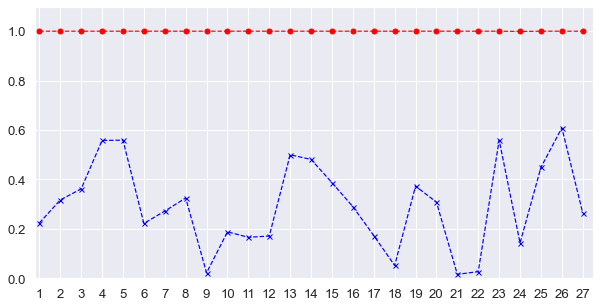

In [22]:
plt.figure(figsize=(10,5))
plt.subplot(111)
events=df['Event']
plt.plot(events,df['POD_S'], linewidth=1.2,color='red', label="POD_S",marker='o',markersize = 5,linestyle="--")
plt.plot(events, df['POD_C'], linewidth=1.2,color='blue', label="POD_C",marker='x',markersize = 5,linestyle="--")
plt.ylim([0.,1.1])
plt.xlim([0.8,27.5])
#plt.ylabel(' RMSE (mm)', fontsize=14)
#plt.grid(False)
#plt.legend(loc='upper right', ncol=3)
plt.xticks(np.arange(1, 28, step=1));
#plt.yticks(np.arange(0, 5, step=0.5))

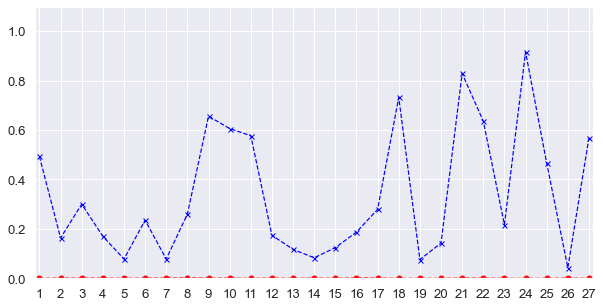

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(111)
events=df['Event']
plt.plot(events,df['FAR_S'], linewidth=1.2,color='red', label="POD_S",marker='o',markersize = 5,linestyle="--")
plt.plot(events, df['FAR_C'], linewidth=1.2,color='blue', label="POD_C",marker='x',markersize = 5,linestyle="--")
plt.ylim([0,1.1])
plt.xlim([0.8,27.2])
#plt.ylabel(' RMSE (mm)', fontsize=14)
#plt.grid(False)
#plt.legend(loc='upper right', ncol=3)
plt.xticks(np.arange(1, 28, step=1));
#plt.yticks(np.arange(0, 5, step=0.5

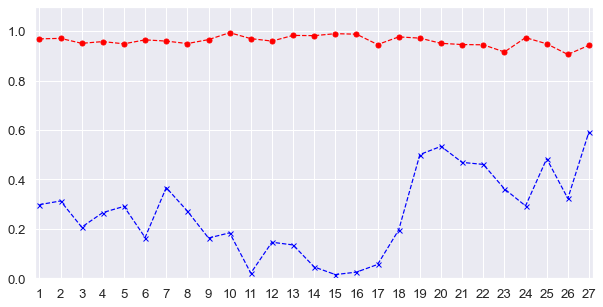

In [57]:
plt.figure(figsize=(10,5))
plt.subplot(111)
events=df['Event']
plt.plot(events,df['CSI_S'], linewidth=1.2,color='red', label="POD_S",marker='o',markersize = 5,linestyle="--")
plt.plot(events, df['CSI_C'], linewidth=1.2,color='blue', label="POD_C",marker='x',markersize = 5,linestyle="--")
plt.ylim([0,1.1])
plt.xlim([0.8,27.2])
#plt.ylabel(' RMSE (mm)', fontsize=14)
#plt.grid(False)
#plt.legend(loc='upper right', ncol=3)
plt.xticks(np.arange(1, 28, step=1));
#plt.yticks(np.arange(0, 5, step=0.5

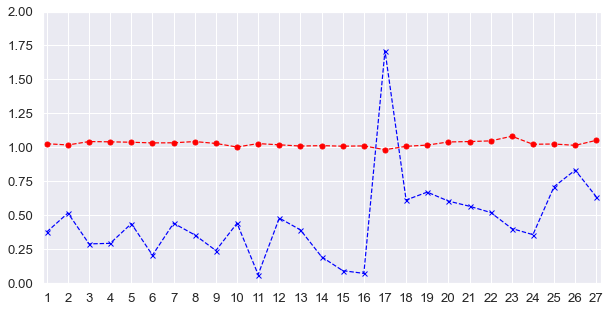

In [59]:
plt.figure(figsize=(10,5))
plt.subplot(111)
events=df['Event']
plt.plot(events,df['BIAS_S'], linewidth=1.2,color='red', label="POD_S",marker='o',markersize = 5,linestyle="--")
plt.plot(events, df['BIAS_C'], linewidth=1.2,color='blue', label="POD_C",marker='x',markersize = 5,linestyle="--")
plt.ylim([0,2])
plt.xlim([0.8,27.2])
#plt.ylabel(' RMSE (mm)', fontsize=14)
#plt.grid(False)
#plt.legend(loc='upper right', ncol=3)
plt.xticks(np.arange(1, 28, step=1));
#plt.yticks(np.arange(0, 5, step=0.5

In [16]:
POD_S=round(S_11/(S_11+p_21),3)
POD_C=round(C_22/(C_22+p_12),3)
FAR_S=round(p_12/(S_11+p_12),3)
FAR_C=round(p_21/(C_22+p_21),3)
CSI_S=round(S_11/(S_11+p_12+p_21),3)
CSI_C=round(C_22/(C_22+p_12+p_21),3)
BIAS_S=round(S_SVM/S_SHY95,3)
BIAS_C=round(C_SVM/C_SHY95,3)
ERR_S=round((1/(S_SVM+C_SVM)*pow(S_SVM-S_SHY95,2))/((pow(S_SHY95,2)/(S_SVM+C_SVM))-(pow(S_SHY95/(S_SVM+C_SVM),2))),3)
ERR_C=round((1/(S_SVM+C_SVM)*pow(C_SVM-C_SHY95,2))/((pow(C_SHY95,2)/(S_SVM+C_SVM))-(pow(C_SHY95/(S_SVM+C_SVM),2))),3)
#Cramer’s Coefficient
data = np.array([[C_SVM,S_SVM], [C_SHY95,S_SHY95]])
X2 = stats.chi2_contingency(data, correction=False)[0]
n = np.sum(data)
minDim = min(data.shape)-1
V = round(np.sqrt((X2/n) / minDim),3)
#Resuls
print("Cramer’s Coefficient, V:",V)
print("Stratiform contingency scores")
print("POD:",POD_S,"FAR:",FAR_S,"CSI:",CSI_S,"ERR:",ERR_S,"BIAS:",BIAS_S)
print("Convective contingency scores")
print("POD:",POD_C,"FAR:",FAR_C,"CSI:",CSI_C,"ERR",ERR_C,"BIAS",BIAS_C)

Cramer’s Coefficient, V: 0.067
Stratiform contingency scores
POD: 0.995 FAR: 0.027 CSI: 0.969 ERR: 0.001 BIAS: 1.023
Convective contingency scores
POD: 0.326 FAR: 0.257 CSI: 0.293 ERR 0.315 BIAS 0.439


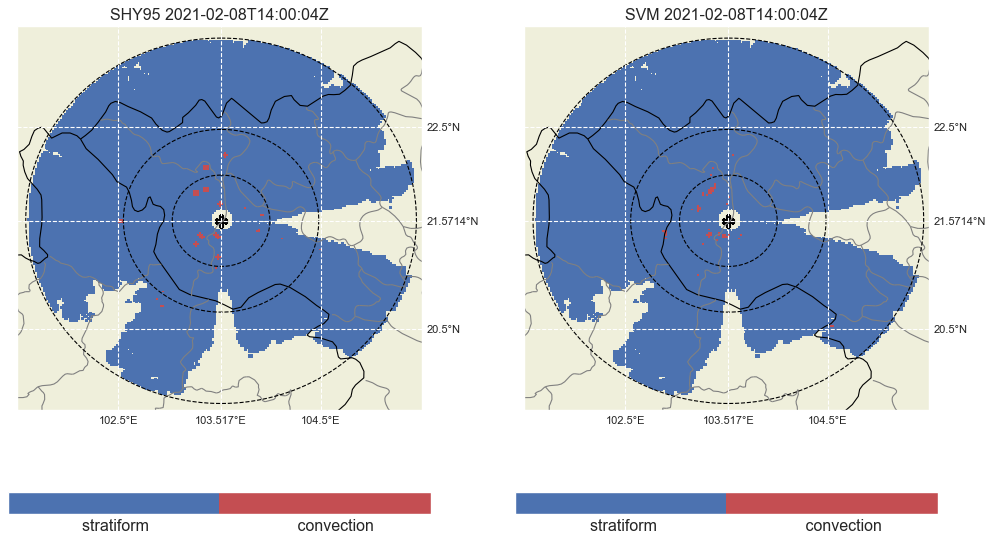

In [27]:
# Draw Range_Rings
circle_points_50km= cargeo.Geodesic().circle(lon=radar.longitude['data'][0],lat=radar.latitude['data'][0], radius=50000, n_samples=180, endpoint=False)
circle_points_100km= cargeo.Geodesic().circle(lon=radar.longitude['data'][0],lat=radar.latitude['data'][0], radius=100000, n_samples=180, endpoint=False)
circle_points_200km= cargeo.Geodesic().circle(lon=radar.longitude['data'][0],lat=radar.latitude['data'][0], radius=200000, n_samples=180, endpoint=False)
geom_50km=Polygon(circle_points_50km)
geom_100km=Polygon(circle_points_100km)
geom_200km=Polygon(circle_points_200km)
#plot map with datas
fig=plt.figure(figsize=(15,20),dpi=80)
ax1=fig.add_subplot(2,2,1, projection=ccrs.PlateCarree())
ax1.add_feature(cfeat.LAND)
ax1.add_feature(cfeat.OCEAN.with_scale('10m'))
ax1.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax1.add_feature(state_provinces_lines,edgecolor='gray')
g1=ax1.gridlines(draw_labels=True,linestyle='--')
g1.xlabels_top = False
g1.ylabels_left = False
g1.xlocator = mticker.FixedLocator([101.5,102.5, grid.x['data'][100], 104.5, 105.5])
g1.ylocator = mticker.FixedLocator([19.5,20.5,grid.y['data'][100],22.5, 23.5])
ax1.set_extent((101.5,105.5,19.7,23.5),crs=ccrs.PlateCarree())
ax1.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
cMap = c.ListedColormap(['b','r'])
lon=grid_lat_lon.x['data']
lat=grid_lat_lon.y['data']
lons,lats=np.meshgrid(lon,lat)
z1_plot=ax1.pcolormesh(lons,lats,SHY95,shading='flat',cmap=cMap)#cmap=cmap,norm=norm)
ax1.scatter(x=radar.longitude['data'][0],y=radar.latitude['data'][0],transform=ccrs.PlateCarree(), color="black",s=100, alpha=1,marker='P')
ax1.set(title="SHY95 "+ radar.time['units'][14:])
plt.colorbar(z1_plot,ax=ax1,orientation='horizontal',ticks=[], label='    stratiform                                 convection')

ax2=fig.add_subplot(2,2,2, projection=ccrs.PlateCarree())
ax2.add_feature(cfeat.LAND)
ax2.add_feature(cfeat.OCEAN.with_scale('10m'))
ax2.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax2.add_feature(state_provinces_lines,edgecolor='gray')
g2=ax2.gridlines(draw_labels=True,linestyle='--')
g2.xlabels_top = False
g2.ylabels_left = False
g2.xlocator = mticker.FixedLocator([101.5,102.5, grid.x['data'][100], 104.5, 105.5])
g2.ylocator = mticker.FixedLocator([19.5,20.5,grid.y['data'][100],22.5, 23.5])
ax2.set_extent((101.5,105.5,19.7,23.5),crs=ccrs.PlateCarree())
ax2.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax2.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax2.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
z2_plot=ax2.pcolormesh(lons,lats,SVM,shading='flat',cmap=cMap)
ax2.scatter(x=radar.longitude['data'][0],y=radar.latitude['data'][0],transform=ccrs.PlateCarree(), color="black",s=100, alpha=1,marker='P');
ax2.set(title="SVM " +radar.time['units'][14:] )
plt.colorbar(z2_plot,ax=ax2,orientation='horizontal',ticks=[], label='    stratiform                                 convection');

In [2]:
Case='General.xlsx'
Case_dic={Case:[*range(1,28,1)]}
SVM_S=[]
SVM_C=[]
SHY95_S=[]
SHY95_C=[]
for r in Case_dic[Case]:
    linkNC='D:/data/SVM_netCDF/'+Case[:-5]+'/'+str(r)+'/'
    print(linkNC)
    C_SVM,C_SHY95,S_SVM,S_SHY95=0,0,0,0
    for file_name in os.listdir(linkNC):
        data=Dataset(linkNC+file_name,'r') # at 1 time
        SVM=data.variables['CS_SVM'][0,:,:]
        SHY95=data.variables['CS_SHY95'][0,:,:]
        S_SVM=S_SVM + SVM[SVM==1].size # number of points SVM = Stratiform
        C_SVM=C_SVM + SVM[SVM==2].size # number of points SVM = Convection
        S_SHY95=S_SHY95 + SHY95[SHY95==1].size # number of points SHY95 = Stratiform
        C_SHY95=C_SHY95 + SHY95[SHY95==2].size # number of points SHY95 = Convection    
        print(file_name)
    SVM_S.append(round(S_SVM/(S_SVM+C_SVM)*100,2))
    SVM_C.append(round(C_SVM/(S_SVM+C_SVM)*100,2))
    SHY95_S.append(round(S_SHY95/(S_SHY95+C_SHY95)*100,2))
    SHY95_C.append(round(C_SHY95/(S_SHY95+C_SHY95)*100,2))

D:/data/SVM_netCDF/General/1/
SVM210208111004.nc
SVM210208112005.nc
SVM210208113004.nc
SVM210208114004.nc
SVM210208115004.nc
SVM210208120004.nc
SVM210208121004.nc
SVM210208122004.nc
SVM210208123004.nc
SVM210208124004.nc
SVM210208125004.nc
SVM210208130005.nc
SVM210208131004.nc
SVM210208132004.nc
SVM210208133004.nc
SVM210208134005.nc
SVM210208135004.nc
SVM210208140004.nc
D:/data/SVM_netCDF/General/2/
SVM210405091004.nc
SVM210405092004.nc
SVM210405093004.nc
SVM210405094003.nc
SVM210405095004.nc
SVM210405100004.nc
SVM210405101004.nc
SVM210405102004.nc
SVM210405103004.nc
SVM210405104004.nc
SVM210405105004.nc
SVM210405110004.nc
SVM210405111003.nc
SVM210405112004.nc
SVM210405113004.nc
SVM210405114004.nc
SVM210405115004.nc
SVM210405120004.nc
SVM210405121004.nc
SVM210405122004.nc
SVM210405123003.nc
SVM210405124004.nc
SVM210405125004.nc
SVM210405130004.nc
D:/data/SVM_netCDF/General/3/
SVM210406061005.nc
SVM210406062003.nc
SVM210406063005.nc
SVM210406064004.nc
SVM210406065004.nc
SVM210406070004.n

SVM220220014004.nc
SVM220220015004.nc
SVM220220020004.nc
SVM220220021004.nc
SVM220220022004.nc
SVM220220023004.nc
SVM220220024004.nc
SVM220220025004.nc
SVM220220030004.nc
SVM220220031004.nc
SVM220220032005.nc
SVM220220033004.nc
SVM220220034004.nc
SVM220220035004.nc
SVM220220040004.nc
SVM220220041004.nc
SVM220220042004.nc
SVM220220043004.nc
SVM220220044004.nc
SVM220220045004.nc
SVM220220050004.nc
D:/data/SVM_netCDF/General/23/
SVM220315101004.nc
SVM220315102003.nc
SVM220315103004.nc
SVM220315104003.nc
SVM220315105004.nc
SVM220315110004.nc
SVM220315111004.nc
SVM220315112004.nc
SVM220315113004.nc
SVM220315114004.nc
SVM220315115004.nc
SVM220315120004.nc
D:/data/SVM_netCDF/General/24/
SVM220316001004.nc
SVM220316002004.nc
SVM220316003005.nc
SVM220316004004.nc
SVM220316005004.nc
SVM220316010005.nc
SVM220316011004.nc
SVM220316012004.nc
SVM220316013004.nc
SVM220316014004.nc
SVM220316015004.nc
SVM220316020003.nc
SVM220316021004.nc
SVM220316022004.nc
SVM220316023004.nc
SVM220316024004.nc
SVM2203

In [3]:
df=pd.DataFrame(data={
    'Events': list(range(1,28,1)),
    'SVM_S':SVM_S,
    'SVM_C':SVM_C,
    'SHY95_S':SHY95_S,
    'SHY95_C':SHY95_C
})

In [40]:
df.to_excel("part1-3.xlsx")

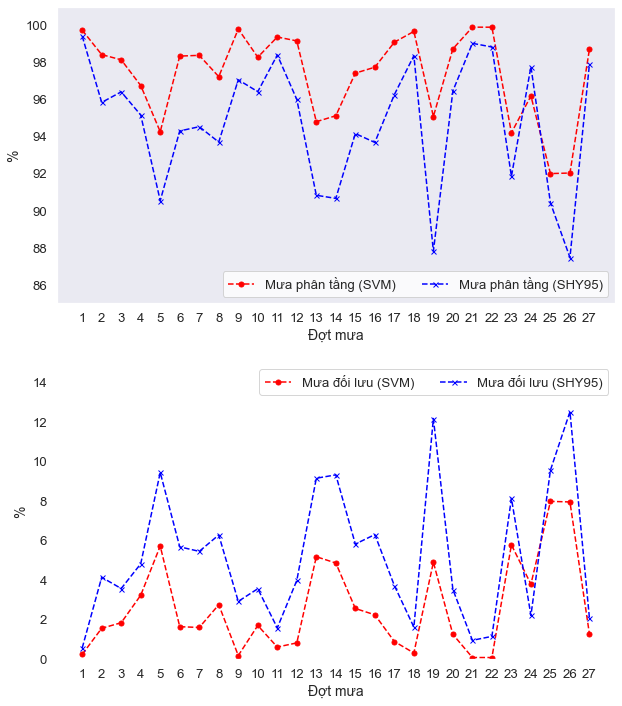

In [39]:
plt.figure(figsize=(10,12),facecolor='white')
plt.subplot(211)
plt.rcParams['axes.facecolor']='white'
events=df['Events']
plt.plot(events,df['SVM_S'], linewidth=1.5,color='red', label="Mưa phân tầng (SVM)",marker='o',markersize = 5,linestyle="--")
plt.plot(events, df['SHY95_S'], linewidth=1.5,color='blue', label="Mưa phân tầng (SHY95)",marker='x',markersize = 5,linestyle="--")
plt.xlabel('Đợt mưa', fontsize=14)
plt.ylim([85,101])
plt.ylabel('%', fontsize=14)
plt.grid(False)
plt.legend(loc='lower right', ncol=2)
plt.xticks(np.arange(1, 28, step=1));
plt.subplot(212)
events=df['Events']
plt.plot(events,df['SVM_C'], linewidth=1.5,color='red', label="Mưa đối lưu (SVM)",marker='o',markersize = 5,linestyle="--")
plt.plot(events, df['SHY95_C'], linewidth=1.5,color='blue', label="Mưa đối lưu (SHY95)",marker='x',markersize = 5,linestyle="--")
plt.xlabel('Đợt mưa', fontsize=14)
plt.ylim([0,15])
plt.ylabel('%', fontsize=14)
plt.grid(False)
plt.legend(loc='upper right', ncol=2)
plt.xticks(np.arange(1, 28, step=1));

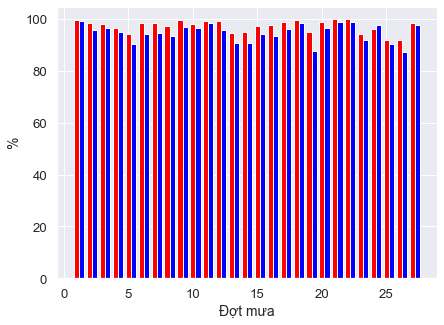

In [36]:
plt.figure(figsize=(15,5))
plt.subplot(121)
bar_width = 0.4
plt.bar(df['Event'],df['SVM_S'],color='red',width=bar_width,label="SVM")#, linewidth=2,color='red', label="CC_Z_ZDR_KDP",marker='o',markersize = 8)
plt.bar(df['Event']+bar_width,df['SHY95_S'],color='blue',width=bar_width,label="SHY95")
plt.ylabel('%',fontsize=14)
plt.xlabel('Đợt mưa',fontsize=14);

<BarContainer object of 27 artists>

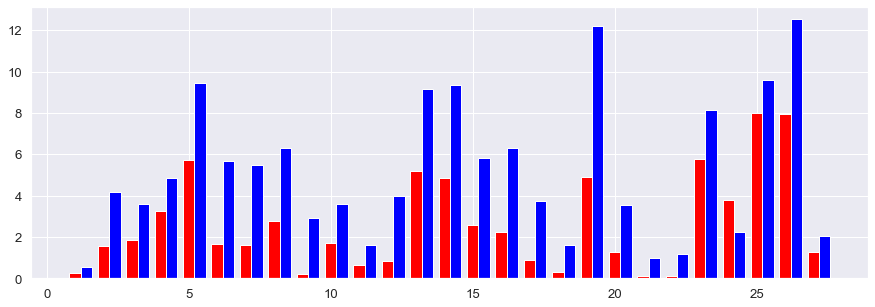

In [31]:
plt.figure(figsize=(15,5))
bar_width = 0.4
plt.bar(df['Event'],df['SVM_C'],color='red',width=bar_width)#, linewidth=2,color='red', label="CC_Z_ZDR_KDP",marker='o',markersize = 8)
plt.bar(df['Event']+bar_width,df['SHY95_C'],color='blue',width=bar_width)

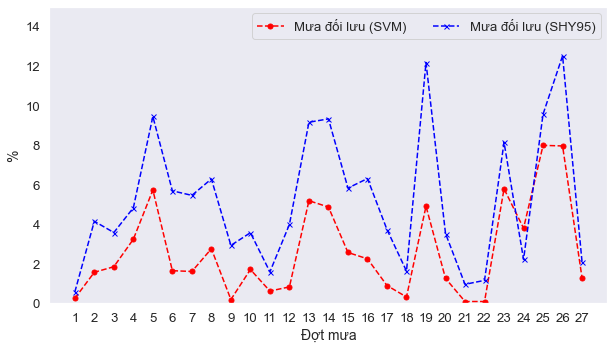

In [36]:
plt.figure(figsize=(10,12),facecolor='white')
plt.subplot(211)
plt.axes().set_facecolor("white")
events=df['Events']
plt.plot(events,df['SVM_S'], linewidth=1.5,color='red', label="Mưa phân tầng (SVM)",marker='o',markersize = 5,linestyle="--")
plt.plot(events, df['SHY95_S'], linewidth=1.5,color='blue', label="Mưa phân tầng (SHY95)",marker='x',markersize = 5,linestyle="--")
plt.xlabel('Đợt mưa', fontsize=14)
plt.ylim([85,101])
plt.ylabel('%', fontsize=14)
plt.grid(False)
plt.legend(loc='lower right', ncol=2)
plt.xticks(np.arange(1, 28, step=1));
plt.subplot(212)
events=df['Events']
plt.plot(events,df['SVM_C'], linewidth=1.5,color='red', label="Mưa đối lưu (SVM)",marker='o',markersize = 5,linestyle="--")
plt.plot(events, df['SHY95_C'], linewidth=1.5,color='blue', label="Mưa đối lưu (SHY95)",marker='x',markersize = 5,linestyle="--")
plt.xlabel('Đợt mưa', fontsize=14)
plt.ylim([0,15])
plt.ylabel('%', fontsize=14)
plt.grid(False)
plt.legend(loc='upper right', ncol=2)
plt.xticks(np.arange(1, 28, step=1));